# S&P 500 Modeling

## Preparation

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

df = pd.read_csv('D:/data/sp500-weekly.csv', index_col = 'Date')
df.index = pd.to_datetime(df.index)

In [2]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-31,1402.430054,1467.939941,1398.109985,1466.469971,1466.469971,14660950000
2013-01-07,1466.469971,1472.750000,1451.640015,1472.050049,1472.050049,18003450000
2013-01-14,1472.050049,1485.979980,1463.760010,1485.979980,1485.979980,17024890000
2013-01-21,1485.979980,1503.260010,1481.160034,1502.959961,1502.959961,14298680000
2013-01-28,1502.959961,1514.410034,1496.329956,1513.170044,1513.170044,18901190000
2013-02-04,1513.170044,1518.310059,1495.020020,1517.930054,1517.930054,17220660000
2013-02-11,1517.930054,1524.689941,1513.609985,1519.790039,1519.790039,17082600000
2013-02-18,1519.790039,1530.939941,1497.290039,1515.599976,1515.599976,15683400000
2013-02-25,1515.599976,1525.839966,1485.010010,1518.199951,1518.199951,19146110000


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,261.000000,261.000000,261.000000,261.000000,261.000000,2.610000e+02
mean,2032.482915,2053.476211,2011.191725,2036.836326,2036.836326,1.707622e+10
std,276.728943,275.979499,278.199243,276.394185,276.394185,3.103877e+09
min,1402.430054,1467.939941,1398.109985,1466.469971,1466.469971,8.194360e+09
25%,1863.920044,1882.349976,1834.439941,1864.780029,1864.780029,1.531024e+10
50%,2050.229980,2076.719971,2022.020020,2051.820068,2051.820068,1.717388e+10
75%,2165.639893,2182.300049,2147.580078,2169.040039,2169.040039,1.890119e+10
max,2685.919922,2694.969971,2676.110107,2683.340088,2683.340088,2.608997e+10


In [4]:
np.std(df['Close'] - df['Adj Close'])

0.0

In [5]:
df = df.drop('Adj Close', 1)

In [6]:
df.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2012-12-31,1402.430054,1467.939941,1398.109985,1466.469971,14660950000
2013-01-07,1466.469971,1472.750000,1451.640015,1472.050049,18003450000
2013-01-14,1472.050049,1485.979980,1463.760010,1485.979980,17024890000
2013-01-21,1485.979980,1503.260010,1481.160034,1502.959961,14298680000
2013-01-28,1502.959961,1514.410034,1496.329956,1513.170044,18901190000
2013-02-04,1513.170044,1518.310059,1495.020020,1517.930054,17220660000
2013-02-11,1517.930054,1524.689941,1513.609985,1519.790039,17082600000
2013-02-18,1519.790039,1530.939941,1497.290039,1515.599976,15683400000
2013-02-25,1515.599976,1525.839966,1485.010010,1518.199951,19146110000


In [7]:
ts = df['Close']

Text(0.5,1,'S&P500 Weekly Closing Index')

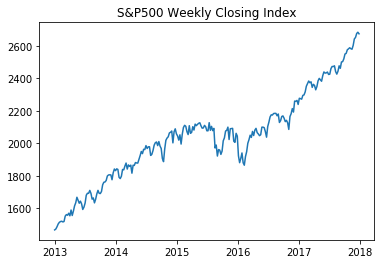

In [8]:
plt.plot(ts)
plt.title('S&P500 Weekly Closing Index')

In [9]:
def convert2lograte(timeSeries):
    result = timeSeries.shift(1)
    result = timeSeries / result
    result.dropna(inplace = True)
    result = np.log(result)
    return result
tsr = convert2lograte(ts)

*Transform the original series to a series of log return ratio*

Text(0.5,1,'Closing Index Log Return Rate')

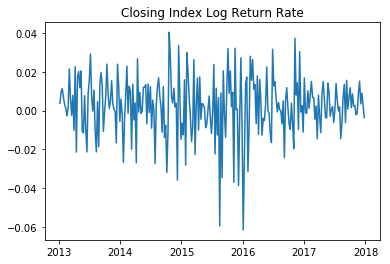

In [10]:
plt.plot(tsr)
plt.title('Closing Index Log Return Rate')

*Our model is based on weekly closing price*

## Stationarity Test

In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels


def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    rol_mean = timeSeries.rolling(window=size).mean()
    rol_weighted_mean = timeSeries.ewm(span=12,min_periods=0,
                                   adjust=True,ignore_na=False).mean()
    rol_std = timeSeries.rolling(window = size).std()


    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    rol_std.plot(color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

def ljboxtest(ts):
    [test_statistic, pvalues] = statsmodels.stats.diagnostic.acorr_ljungbox(ts)
    ljboxoutput = pd.Series(pvalues[4,9], index = ['p-value for Q(5)', 
                                                   'p-value for Q(10)'])
    return ljboxoutput

def draw_acf_pacf(ts, lags=31):
    plot_acf(ts, lags=lags)
    plot_pacf(ts, lags=lags)
    plt.show()

C:\Users\charl\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


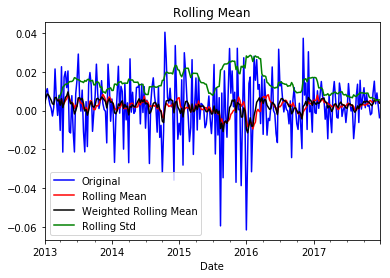

Test Statistic                -7.856133e+00
p-value                        5.436661e-12
#Lags Used                     6.000000e+00
Number of Observations Used    2.530000e+02
Critical Value (1%)           -3.456464e+00
Critical Value (5%)           -2.873033e+00
Critical Value (10%)          -2.572895e+00
dtype: float64


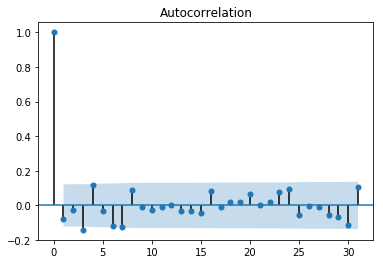

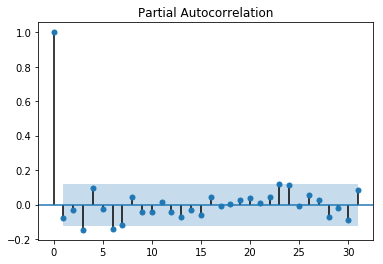

In [12]:
draw_trend(tsr,12)
print(testStationarity(tsr))
draw_acf_pacf(tsr)

The series is now stationary, but it seems to be a series of white noise......

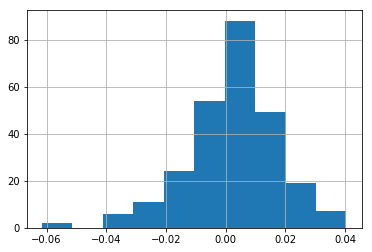

In [13]:
tsr.hist()

## ARMA Modeling

Based on acf-plot and pacf-plot, we choose ARMA(0,1)

Text(0.5,1,'RSS: 0.0578')

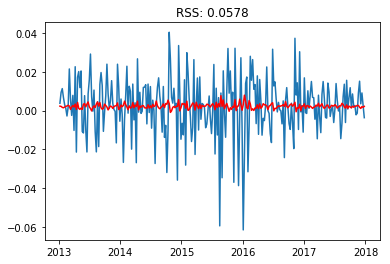

In [32]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(tsr, order = (0,1))
result_arma = model.fit(disp = -1)
plt.plot(tsr)
plt.plot(result_arma.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((result_arma.fittedvalues-tsr)**2))